In [1]:
from hmmlearn import hmm
from python_speech_features import mfcc
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection  import train_test_split
import librosa
import sklearn.metrics as sk_metrics
from scipy.stats import multivariate_normal

In [2]:
folder_path = 'recordings'
digits = range(0, 10)
speakers = ["george", "jackson", "lucas", "nicolas", "theo", "yweweler"] 

In [3]:
def get_audio_digit(i):
    audio_files = []
    for file in os.listdir(folder_path):
        if file.startswith(str(i)):
            audio_files.append(os.path.join(folder_path, file))
    return audio_files

def get_digit_seg():
    digit_based_seg = []
    for i in digits:
        digit_based_seg.append(get_audio_digit(i))
    return digit_based_seg

In [4]:
def get_audio_speaker(speaker):
    audio_files = []
    for file in os.listdir(folder_path):
        if speaker in file:
            audio_files.append(os.path.join(folder_path, file))
    return audio_files

def get_speaker_seg():
    speaker_based_seg = []
    for speaker in speakers:
        speaker_based_seg.append(get_audio_speaker(speaker))
    return speaker_based_seg

In [5]:
def calc_mfcc(audio_files):
    mfcc_seg = []
    result_len = 30
    for seg in audio_files:
        seg_mfcc = []
        for file in seg:
            (rate, signal) = wav.read(file)
            signal, _ = librosa.effects.trim(signal, top_db=50, frame_length=1024)
            result = mfcc(signal, rate, nfft=1024)
            if (len(result) < result_len):
                cor_result = np.pad(result, ((0, result_len-len(result)), (0, 0)))
            else:
                cor_result = result[:result_len, :]
            seg_mfcc.append(cor_result)
        mfcc_seg.append(seg_mfcc)
    return mfcc_seg

In [6]:
def plot_heatmap(mfcc):
    fig, ax = plt.subplots()
    im = ax.imshow(mfcc.T, cmap='viridis', aspect='auto')
    ax.set_ylabel('MFCC Coefficients')
    ax.set_xlabel('Time')
    fig.colorbar(im)
    plt.show()

In [7]:
digit_based_seg = get_digit_seg()
mfcc_digit_seg = calc_mfcc(digit_based_seg)

FileNotFoundError: [Errno 2] No such file or directory: 'recordings'

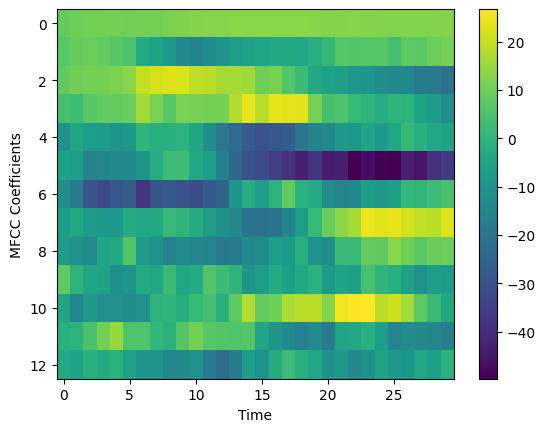

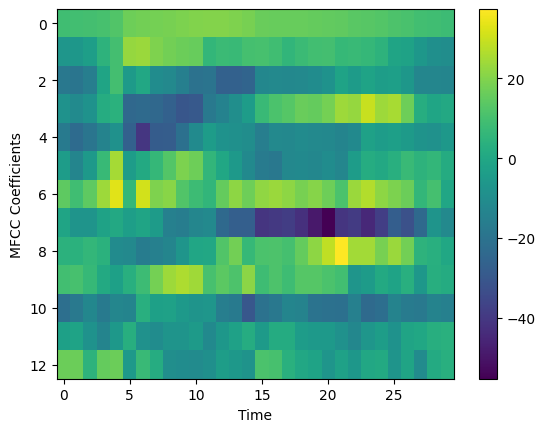

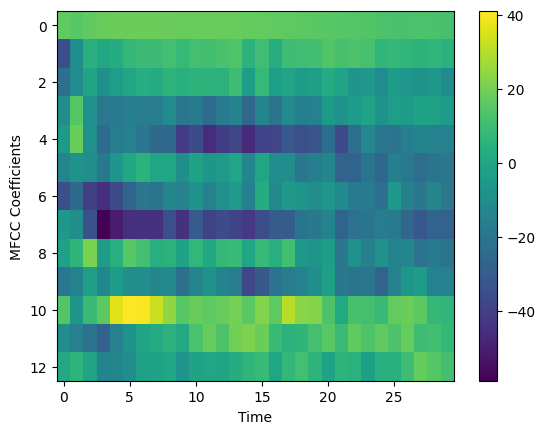

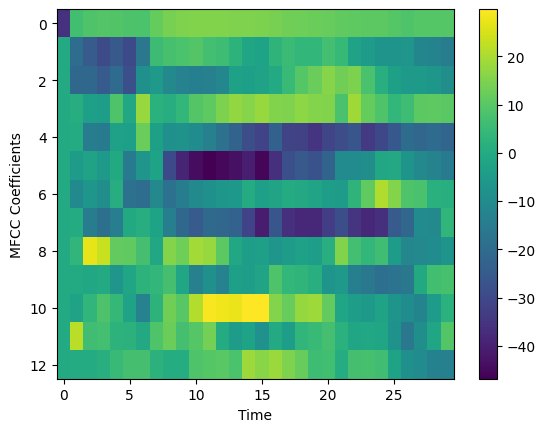

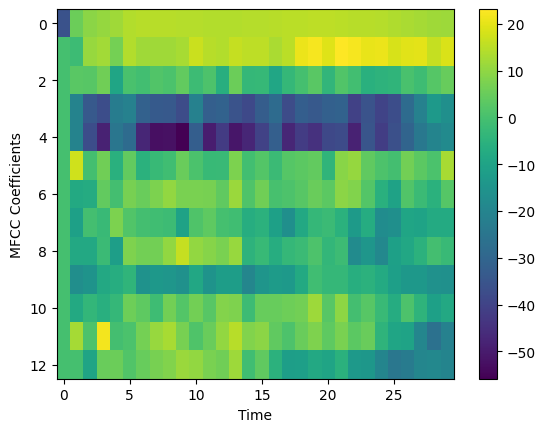

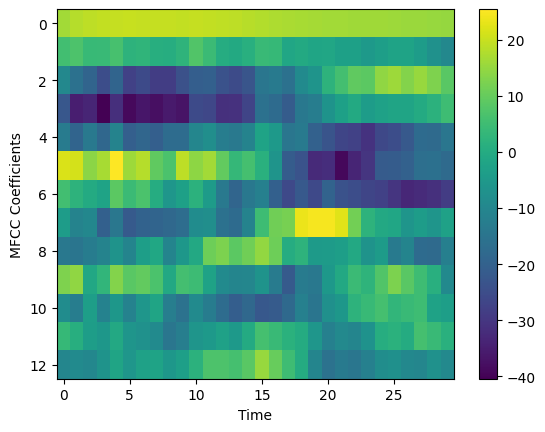

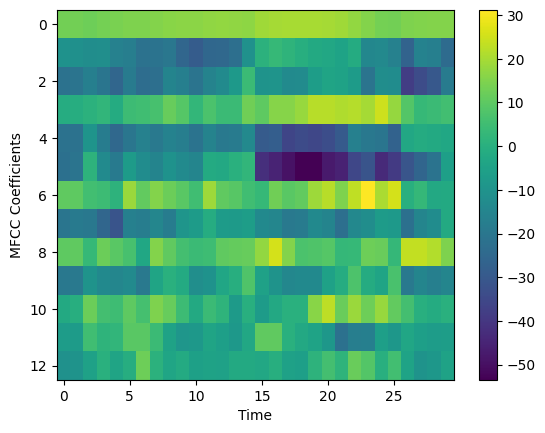

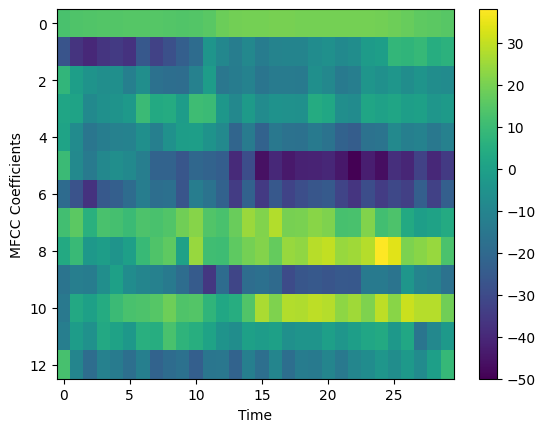

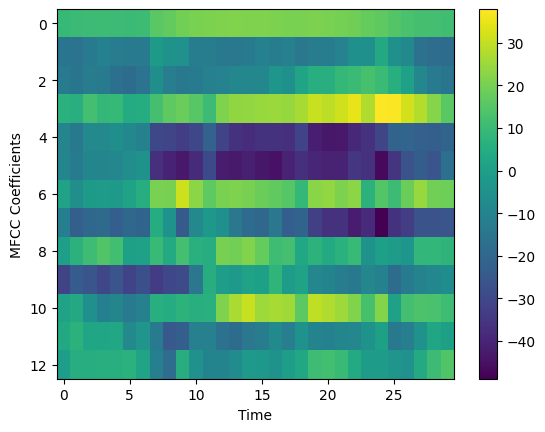

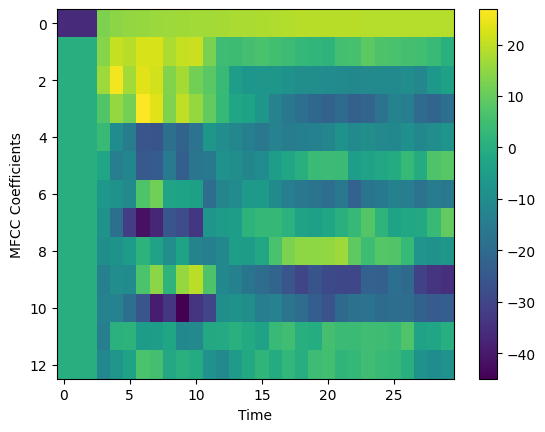

In [ ]:
for digit in mfcc_digit_seg:
    plot_heatmap(digit[0])

In [ ]:
def create_dataset(mfccs, labels, class_cnt):
    train_dict = dict()
    mfcc_test = []
    label_test = []
    for i in range(class_cnt):
        mfcc_train, x_test, _, y_test = train_test_split(np.array(mfccs[i]), np.array(labels[i]), test_size=0.1)
        mfcc_test.extend(x_test)
        label_test.extend(y_test)
        train_dict[i] = mfcc_train.reshape((-1, mfcc_train.shape[2]))
    mfcc_test = np.array(mfcc_test)
    label_test = np.array(label_test)
    return train_dict, mfcc_test, label_test

In [ ]:
def train_models(dic, state_cnt, class_cnt):
    models = []
    for i in range(class_cnt):
        model = hmm.GaussianHMM(n_components=state_cnt, covariance_type='tied')
        model.fit(dic[i])
        models.append(model)
    return models

In [ ]:
def apply_model(trained_models, mfcc_test):
    train_predictions = []
    for i in range(mfcc_test.shape[0]):
        scores = []
        for model in trained_models:
            model_score = model.score(mfcc_test[i,:])
            scores.append(model_score)
        label = np.argmax(np.array(scores))
        train_predictions.append(label)
    return train_predictions

In [ ]:
def calc_confusion_matrix(label_test, predictions, class_cnt):
    matrix = [[0] * class_cnt for i in range(class_cnt)]
    for x, y in zip(label_test, predictions):
        matrix[x][y] += 1
    whole_class = [sum(1 for x in label_test if x == i) for i in range(class_cnt)]
    for i in range(class_cnt):
        for j in range(class_cnt):
            if whole_class[i] == 0:
                perc = 0
            else:
                perc = matrix[i][j] / whole_class[i] * 100
            matrix[i][j] = round(perc, 2)
    return matrix

In [ ]:
def plot_confusion_matrix(conf_matrix, class_labels):
    fig, ax = plt.subplots()
    im = ax.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Purples)
    ax.set_title('Confusion Matrix')
    fig.colorbar(im)
    ax.set_xticks(np.arange(len(class_labels)))
    ax.set_yticks(np.arange(len(class_labels)))
    ax.set_xticklabels(class_labels)
    ax.set_yticklabels(class_labels)
    for i in range(len(class_labels)):
        for j in range(len(class_labels)):
            ax.text(j, i, str(round(conf_matrix[i][j], 2)), ha='center', va='center', color='black')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()

In [ ]:
def calc_accuracy(label_test, predictions):
    correct = sum(1 for x, y in zip(label_test, predictions) if x == y)
    accuracy = correct / len(predictions)
    return accuracy

In [ ]:
def calc_precision(label_test, predictions, class_cnt):
    classes_precision = [0 for i in range(class_cnt)]
    for x in range(class_cnt):
        cor_positives = sum(1 for i, j in zip(label_test, predictions) if i == j and j == x)
        whole = sum(1 for i in predictions if i == x)
        if whole == 0:
            classes_precision[x] = 0
        else:
            classes_precision[x] = cor_positives / whole
    precision = sum(classes_precision) / len(classes_precision)
    return precision

Digit based segmentation:

In [ ]:
mfcc_digit_tags = []
for i in range(len(mfcc_digit_seg)):
    digit_mfccs = mfcc_digit_seg[i]
    tag_list = [i] * len(digit_mfccs)
    mfcc_digit_tags.append(tag_list)

In [ ]:
train_dict, mfcc_test, label_test = create_dataset(mfcc_digit_seg, mfcc_digit_tags, len(digits))
state_cnt_digit = 1
trained_models = train_models(train_dict, state_cnt_digit, len(digits))
predictions = np.array(apply_model(trained_models, mfcc_test))

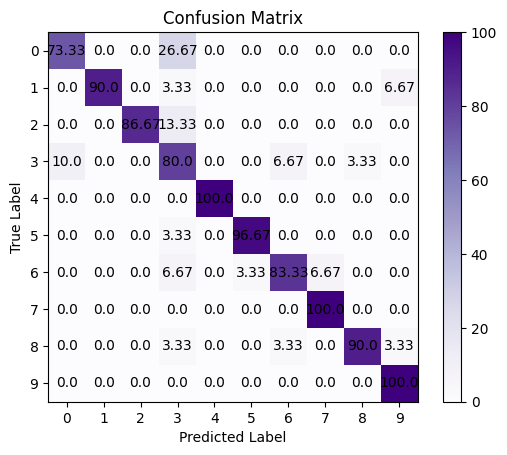

In [ ]:
matrix = calc_confusion_matrix(label_test, predictions, len(digits))
plot_confusion_matrix(matrix, digits)

In [ ]:
accuracy = calc_accuracy(label_test, predictions)
precision = calc_precision(label_test, predictions, len(digits))
print("Accuracy:", accuracy)
print("Precision:", precision)

Accuracy: 0.9
Precision: 0.9135766286558968


Speaker based segmentation:

In [ ]:
speaker_based_seg = get_speaker_seg()
mfcc_speaker_seg = calc_mfcc(speaker_based_seg)

In [ ]:
mfcc_speaker_tags = []
for i in range(len(mfcc_speaker_seg)):
    speaker_mfccs = mfcc_speaker_seg[i]
    tag_list = [i] * len(speaker_mfccs)
    mfcc_speaker_tags.append(tag_list)

In [ ]:
train_dict, mfcc_test, label_test = create_dataset(mfcc_speaker_seg, mfcc_speaker_tags, len(speakers))
state_cnt_speaker = 1
trained_models = train_models(train_dict, state_cnt_speaker, len(speakers))
predictions = np.array(apply_model(trained_models, mfcc_test))

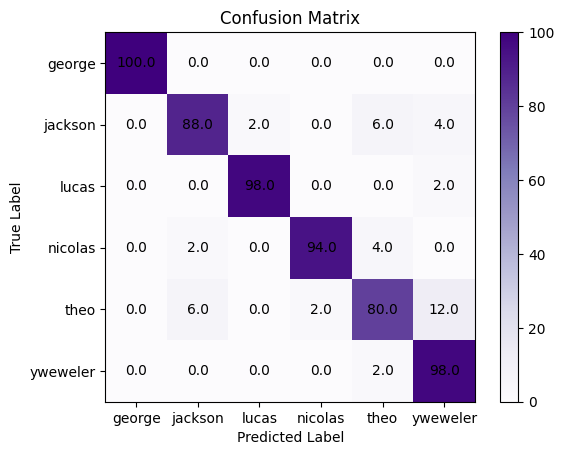

In [ ]:
matrix = calc_confusion_matrix(label_test, predictions, len(speakers))
plot_confusion_matrix(matrix, speakers)

In [ ]:
accuracy = calc_accuracy(label_test, predictions)
precision = calc_precision(label_test, predictions, len(digits))
print("Accuracy:", accuracy)
print("Precision:", precision)

Accuracy: 0.93
Precision: 0.5590226136931534


In [ ]:
class HMM:
    def __init__(self, num_hidden_states):
        self.num_hidden_states = num_hidden_states
        self.rand_state = np.random.RandomState(1)

        self.initial_prob = self._normalize(self.rand_state.rand(self.num_hidden_states, 1))
        self.transition_matrix = self._stochasticize(self.rand_state.rand(self.num_hidden_states, self.num_hidden_states))

        self.mean = None
        self.covariances = None
        self.num_dimensions = None

    def _forward(self, observation_matrix):
        log_likelihood = 0.
        T = observation_matrix.shape[1]
        alpha = np.zeros(observation_matrix.shape)

        for t in range(T):
            if t == 0:
                alpha[:,0] =  self.initial_prob.flatten() * observation_matrix[:, t]
            else:
                alpha[:,t] = np.matmul(self.transition_matrix.T,alpha[:, t-1]) * observation_matrix[:, t]

            alpha_sum = np.sum(alpha[:, t])
            alpha[:, t] /= alpha_sum
            log_likelihood += np.log(alpha_sum)

        return log_likelihood, alpha

    def _backward(self, observation_matrix):
        T = observation_matrix.shape[1]
        beta = np.zeros(observation_matrix.shape)

        beta[:, -1] = np.ones(observation_matrix.shape[0])

        for t in range(T - 1)[::-1]:
            beta[:, t] = np.matmul(self.transition_matrix, (observation_matrix[:, t+1] * beta[:, t+1]))
            beta[:, t] /= np.sum(beta[:, t])

        return beta

    def _state_likelihood(self, obs):
        obs = np.atleast_2d(obs)
        B = np.zeros((self.num_hidden_states, obs.shape[1]))

        for s in range(self.num_hidden_states):
            np.random.seed(self.rand_state.randint(1))
            B[s, :] = multivariate_normal.pdf(obs.T, mean=self.mean[:, s], cov=self.covariances[:, :, s])

        return B

    def _normalize(self, x):
        return (x + (x == 0)) / np.sum(x)

    def _stochasticize(self, x):
        return (x + (x == 0)) / np.sum(x, axis=1)

    def _em_init(self, obs):
        if self.num_dimensions is None:
            self.num_dimensions = obs.shape[0]
        if self.mean is None:
            subset = self.rand_state.choice(np.arange(self.num_dimensions), size=self.num_hidden_states, replace=False)
            self.mean = obs[:, subset]
        if self.covariances is None:
            self.covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
            self.covariances += np.diag(np.diag(np.cov(obs)))[:, :, None]

        return self

    def _em_step(self, obs):
        obs = np.atleast_2d(obs)
        T = obs.shape[1]

        B = self._state_likelihood(obs=obs)

        log_likelihood, alpha = self._forward(B)
        beta = self._backward(B)

        xi_sum = np.zeros((self.num_hidden_states, self.num_hidden_states))
        gamma = np.zeros((self.num_hidden_states, T))

        for t in range(T - 1):
            partial_sum = sum(alpha[:, t] * beta[:, t+1] * B[:, t+1]) * self.transition_matrix
            xi_sum += self._normalize(partial_sum)
            partial_g = alpha[:,t] * beta[:, t]
            gamma[:, t] = self._normalize(partial_g)
        partial_g = alpha[:, T-1] * beta[:, T-1]
        gamma[:, -1] = self._normalize(partial_g)

        expected_prior = gamma[:,0]
        expected_transition = self._stochasticize(xi_sum/np.sum(xi_sum, axis=(0, 1)))

        expected_covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
        expected_covariances += .01 * np.eye(self.num_dimensions)[:, :, None]

        gamma_state_sum = np.sum(gamma, axis=1)
        gamma_state_sum = gamma_state_sum + (gamma_state_sum == 0)

        expected_mean = np.zeros((self.num_dimensions, self.num_hidden_states))
        for s in range(self.num_hidden_states):
            gamma_obs = obs * gamma[s, :]
            expected_mean[:, s] = np.sum(gamma_obs, axis=1) / gamma_state_sum[s]

        self.initial_prob = expected_prior
        self.mean = expected_mean
        self.covariances = expected_covariances
        self.transition_matrix = expected_transition

        return log_likelihood

    def train(self, obs, num_iterations=1):
        for i in range(num_iterations):
            self._em_init(obs)
            self._em_step(obs)
        return self

    def score(self, obs):
        B = self._state_likelihood(obs)
        log_likelihood, _ = self._forward(B)
        return log_likelihood

In [ ]:
def scratch_train_models(dic, state_cnt, class_cnt):
    models = []
    for i in range(class_cnt):
        model = HMM(num_hidden_states=state_cnt)
        model.train(dic[i].T / np.amax(dic[i].T), num_iterations=10)
        models.append(model)
    return models

In [ ]:
def scratch_apply_models(trained_models, mfcc_test):
    train_predictions = []
    for mfcc in mfcc_test:
        scores = []
        for model in trained_models:
            model_score = model.score(mfcc.T / np.amax(mfcc.T))
            scores.append(model_score)
        label = np.argmax(np.array(scores))
        train_predictions.append(label)
    return train_predictions

In [ ]:
state_cnt = 10
train_dict, mfcc_test, label_test = create_dataset(mfcc_digit_seg, mfcc_digit_tags, len(digits))
scratch_models = scratch_train_models(train_dict, state_cnt, len(digits))
predictions = np.array(scratch_apply_models(scratch_models, mfcc_test))

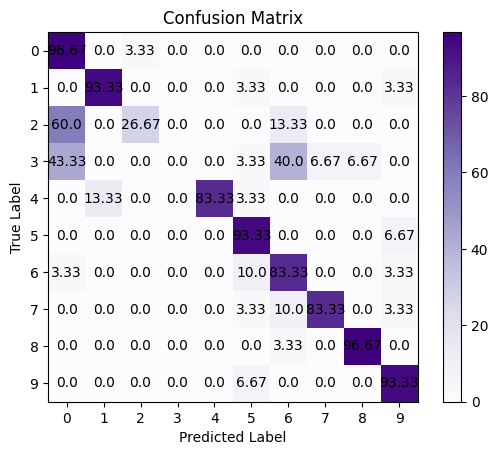

In [ ]:
matrix = calc_confusion_matrix(label_test, predictions, len(digits))
plot_confusion_matrix(matrix, digits)

In [ ]:
accuracy = calc_accuracy(label_test, predictions)
precision = calc_precision(label_test, predictions, len(digits))
print("Accuracy:", accuracy)
print("Precision:", precision)

Accuracy: 0.75
Precision: 0.7261505682645291


In [ ]:
state_cnt = 10
train_dict, mfcc_test, label_test = create_dataset(mfcc_speaker_seg, mfcc_speaker_tags, len(speakers))
scratch_models = scratch_train_models(train_dict, state_cnt, len(speakers))
predictions = np.array(scratch_apply_models(scratch_models, mfcc_test))

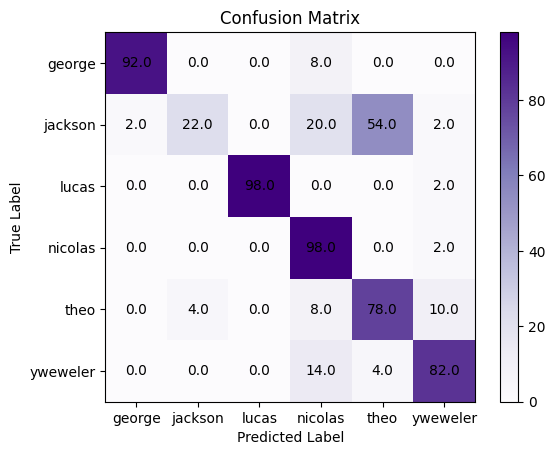

In [ ]:
matrix = calc_confusion_matrix(label_test, predictions, len(speakers))
plot_confusion_matrix(matrix, speakers)

In [ ]:
accuracy = calc_accuracy(label_test, predictions)
precision = calc_precision(label_test, predictions, len(digits))
print("Accuracy:", accuracy)
print("Precision:", precision)

Accuracy: 0.7833333333333333
Precision: 0.4897303518213584
